<img src="https://github.com/BigDataGrapes-EU/deliverable-D4.3/blob/master/volume-data/spark-master-notebook/notebooks/images/BDG_LOGO.png?raw=true" alt="drawing" align="right" width="200"/>

# H2020 RIA BigDataGrapes - Predictive Data Analytics (T4.3)

## The D4.3 deliverable presents how to train machine learning models with the BigDataGrapes distributed processing architecture. This fourth demonstrator has been added to this document as an update done at M15. The demonstrator focuses on the application of machine learning methods on wine data collected from online social networks of wine passionate users. The predictive analysis conducted on this dataset allows us to show the potential of the machine learning layer of the BDG infrastructure providing efficient and effective methods for assessing the potential market penetration of a given wine in a new country.

In [43]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc 
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer,RegexTokenizer
from pyspark import SparkContext

import pandas as pd #pandas
import numpy as np #numpy
from scipy import spatial #for cosine distance

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

## Connection to the BDG Apache Spark

In [ ]:
#SparkContext tells Spark how and where to access a cluster
#sc = SparkContext(appName="WineDatasetAnalysis", master="local[*]")
sc = SparkContext(appName="WineDatasetAnalysis", master="spark://node1.novello.isti.cnr.it:7077")
sc.setLogLevel("DEBUG")

#  SparkSession provides a single point of entry to interact with underlying Spark functionality and allows programming Spark with DataFrame and Dataset APIs.
spark = SparkSession.builder.appName("Analysis").getOrCreate()

# Load Dataset


In [27]:
df = spark.read.csv("WineDataset.csv", sep=',', escape='"', header=True, inferSchema=True)
df.cache() # help save partial intermediate results so that they can be reused in later stages.
df.count()

489417

In [59]:
df.columns

['review_language',
 'review_text',
 'review_rating',
 'aroma_word_matches',
 'taste_word_matches',
 'user_id',
 'user_country',
 'user_state',
 'wine_name',
 'wine_grapes',
 'wine_foods',
 'wine_country_name',
 'wine_region_name',
 'wine_year',
 'wine_alcohol',
 'wine_style_acidity',
 'wine_style_body',
 'wine_style_wine_id']

The data available consist of a general description of the wine (wine name, producer, year of production, wine grape varieties, etc.), user-generated content associated with it (user ratings and reviews), and user information (unique Id, nationality, etc.). 

* review_language: review language 
* review_text: review text
* review_rating: review  rating 
* aroma_word_matches: aromas in the review
* taste_word_matches: tastes in the review (from https://winefolly.com/tutorial/wine-aroma-wheel-100-flavors/ )
* user_id: user  id
* user_country: reviewer  country
* wine_name: name of the wine reviewed 
* wine_grapes: grapes used in the wine reviewed 
* Wine_foods: foods to be paired with the wine reviewed 
* wine_country_name: country of the reviewed wine
* wine_region_name: region of the reviewed wine
* wine_year: year of production of the reviewed wine
* wine_alcohol: %alcohol of the reviewed wine 
* wine_style_acidity: acidity level of the wine reviewed (1:low, 2:Medium, 3:High)
* wine_style_body: level of body of the wine reviewed (1:Very light-bodied,2:Light-bodied;3:Medium-bodied; 4:Full-bodied; 5:Very full-bodied)
* wine_style_wine_id: type of wine reviewed (1:red, 2:white, 3: sparkling, 4:rose; 24:fortified; 7:sauternes)




## Preliminary Analysis
We first perform a preliminary analysis of the data available. 

In [52]:
print(" # wine name: ", df.select("wine_name").dropna().distinct().count())
print(" # wine country: ", df.select("wine_country_name").dropna().distinct().count())
print(" # wine region: ", df.select("wine_region_name").dropna().distinct().count())   
print(" # user: ", df.select("user_id").dropna().distinct().count())
print(" # user country: ", df.select("user_country").dropna().distinct().count())
print(" # review language : ", df.select("review_language").dropna().distinct().count())
df =df.drop('user_id') # not useful for the analysis

 # wine name:  51579
 # wine country:  58
 # wine region:  2272
 # user :  195678
 # user country:  225
 # review language :  86


The dataset used contains: 489,417 wine reviews by 195,678 users, written in 86 languages, related to 51,579 different wines, from 58 wine countries and 2272 wine regions. The following Table shows the number of reviews in the dataset after data cleaning grouped by language.

In [51]:
# top language
top_country = df.groupby('review_language').count().sort(desc("count"))
top_country = top_country.filter(df.review_language!='un').dropna()  #remove null and 'unkown' value
top_country.show(5)

+---------------+------+
|review_language| count|
+---------------+------+
|             en|357347|
|             fr| 17166|
|             pt| 13007|
|             it| 10949|
|             de|  8388|
+---------------+------+
only showing top 5 rows




We note that English is the most popular language. We thus focus our analysis on the reviews written in English. 



In [30]:
df_en = df[df.review_language=='en']

## Get top-5 countries

We now detail the  distribution per user country of the reviews written in English.

In [53]:
# top 5 countries with review in English language
top_country = df_en.groupby('user_country').count().sort(desc("count")).dropna().limit(5)
top_country_a = np.array(top_country.rdd.map(lambda r: (r[0])).collect()) # top country in array
top_country_a = top_country_a.flatten()
top_country.show()

+------------+------+
|user_country| count|
+------------+------+
|          us|114497|
|          gb| 35925|
|          nl| 17703|
|          au| 16099|
|          ca| 15496|
+------------+------+



TOP 5 Contries are USA, Great Britain Australia, Netherlands,  Canada

## Get top-5 wines

In [52]:
# top 5 wines with review in English language
top_wine = df_en.groupby('wine_name').count().sort(desc("count")).dropna().limit(5)
top_wine_a  =np.array(top_wine.rdd.map(lambda r: (r[0])).collect()) # top wine in array
top_wine_a =top_wine_a.flatten()
print("Top Wines in English Review: ",top_wine_a)

Top Wines in English Review:  ['cabernet-sauvignon' 'chardonnay' 'pinot-noir' 'merlot' 'sauvignon-blanc']


5  popular wine type are : cabernet-sauvignon, chardonnay, pinot-noir, 'merlot and sauvignon-blanc

## Rating Histogram

Another interesting analysis regards the distribution of the wine rating that is expressed on a nine-graded scale from one to five, where one means “very bad” while five means “excellent”. We plot the distribution of the user ratings to understand what are the most popular classes. The chart below shows the number of reviews (Y axis) per rating value (X axis).

In [45]:
data = [go.Histogram(x=df_en.toPandas()['review_rating'])]
layout = go.Layout(title='Histogram Rating', xaxis=dict(range=[0, 5]))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

We observe that the most popular classes are 3, 3.5, 4. These three classes cover together up to 270K reviews consisting in the majority of the reviews present in the dataset

# Building taste and aroma profiles of a wine
We now show how to exploit user reviews to build an aroma profile of a wine. To this end we select from our dataset the user reviews written in English. The generation of the aroma profile is done by identifying in the text of the reviews the occurrences of terms belonging to a taxonomy of wine aromas provided by one of the most popular social networks of wine lovers.

## Aroma Profiles

We creates hot encoding vector  for aroma (ohe_aroma) contained in review text. Each vector measures the presence of specific aromas in the reviews. This is why we use one hot encoder to perform “binarization” of the aroma_word_matches category feature

In [46]:
df2 = df_en.filter(df.aroma_word_matches.isNotNull()) # filter not null 'aroma_word_matches'

#tokenize    
tokenizer = RegexTokenizer(inputCol='aroma_word_matches', outputCol='tokenized', pattern='[^a-zA-Z]+')

#count vectorizer (one hot encoding) 
cv = CountVectorizer(inputCol="tokenized", outputCol="ohe_aroma", vocabSize=300)

pipeline = Pipeline(stages=[tokenizer,cv])
model = pipeline.fit(df2)
result = model.transform(df2)
result.select('ohe_aroma').show(3)

+--------------------+
|           ohe_aroma|
+--------------------+
|   (300,[153],[1.0])|
|(300,[5,11,22,25,...|
|(300,[3,6,22,45,9...|
+--------------------+
only showing top 3 rows



By using the ohe_aroma, we thus build a multi-dimensional fingerprint of aromas perceived as characterizing a specific wine group on the basis of the user country. 
We aggregates the one hot encoder vectors  of each group of wines in order to obatin a term frequency vector where each element of the vector is the frequency of a specific aroma in the user reviews. After a normalization process, the per-country multi-dimensional vectors enable interesting similarity operations thus measuring the perception of the same wine type in different countries. 




In [58]:
def plotHeatmap(df, wine_name, ohe_colname, vocabulary):
    df_wine = df[df['wine_name'] == wine_name] # filter wine name
    count_vec_tot = []
    vocabulary_tot = []
    country_tot = []   

    #Get data
    for country in top_country_a:
        dfc = df_wine[df_wine['user_country'] == country] # filter country
        x_3d = np.array(dfc.select(ohe_colname).collect()) # get One Hot Encoding

        if len(x_3d.shape) < 3: 
            continue #not ne Hot Encoding vectors for this country 

        rows, idx, vocabsize = x_3d.shape
        X = x_3d.reshape(rows, vocabsize)
        count_vec = np.sum(X,axis=0) # sum One Hot Encoding vectors
        count_vec_country = count_vec/np.max(count_vec) # minmax scaler One Hot Encoding vectors
        address__country = [country] * len(vocabulary) # for visulization purpose (heap map)

        count_vec_tot.extend(count_vec_country) #
        vocabulary_tot.extend(vocabulary)
        country_tot.extend(address__country)


    dfh = pd.DataFrame()  # dataframe for heatmap
    dfh['x'] = vocabulary_tot
    dfh['y'] = country_tot
    dfh['z'] = count_vec_tot
    dfh = dfh[dfh['z']>0.4] #remove low frequencies aromas (or tastes)  


    #Plot Heatmap Taste or Aroms    
    trace = go.Heatmap(z=dfh['z'],
                     x=dfh['x'],
                     y=dfh['y'], colorscale='Jet')

    title1 = "Tastes on " if ohe_colname=='ohe_taste' else "Aromas on "
    layout = go.Layout(
      title= title1+wine_name,
      width=1100,
      height=500,
      font=dict(family='Arial, monospace', size=17, color='#000000')
    )

    data=[trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    # plot country similarity
    sim_mat = [] # similarity matrix
    n_country = int(len(count_vec_tot)/len(vocabulary))
    vec_country = np.array(count_vec_tot).reshape(n_country,len(vocabulary)) #get vector

    # vec_country = np.where(vec_country > 0.4, vec_country, 0)  #remove low frequencies aroms (or tastes)  

    #calculate similarity matrix
    for v1 in vec_country:  
        row = []
        for v2 in vec_country:  
          #dist = distance.cityblock(v1, v2)  # distance manhattan      
            sym = 1 - spatial.distance.cosine(v1, v2)
            row.append(sym) #add similarity
        row = (row - np.min(row)) / (np.max(row) - np.min(row))  # min max scaling (1 max similarity, 0 min similarity)
        sim_mat.append(row) #add to matrix


    trace = go.Heatmap(z=sim_mat,x=dfh['y'].unique(),y=dfh['y'].unique())
    layout = go.Layout(
      title= "Country Similarity ("+title1+wine_name+")",
      width=1100,
      height=500,
      font=dict(family='Arial, monospace', size=17, color='#000000')
    )

    data=[trace]
    fig = go.Figure(data=data, layout=layout)  
    iplot(fig)  

We built  the fingerprints of the most popular wine group, (cabernet-sauvignon, chardonnay, pinot-noir, 'merlot and sauvignon-blanc)  for the top five most-popular countries (US, GB, NL, AU, CA). 

The heat-map plots the frequency of each aroma in the user reviews of each specific country. 

In [59]:
cv_model = model.stages[-1]
vocabulary_flavor = cv_model.vocabulary #get vocabulary_flavor
for wine in top_wine_a:
    plotHeatmap(result, wine,'ohe_aroma',vocabulary_flavor)


## Taste Profiles

We creates hot encoding vector  for taste (ohe_taste) contained in review text. Each vector measures the presence of specific taste term in the reviews.

In [65]:
df_taste = df_en.filter(df.taste_word_matches.isNotNull()) # filter not null 'taste_word_matches'

#tokenize    
tokenizer = RegexTokenizer(inputCol='taste_word_matches', outputCol='tokenized', pattern='[^a-zA-Z]+')

#count vectorizer (one hot encoding) 
cv = CountVectorizer(inputCol="tokenized", outputCol="ohe_taste", vocabSize=300)

pipeline = Pipeline(stages=[tokenizer,cv])
model = pipeline.fit(df_taste)
result = model.transform(df_taste)
result.select('ohe_taste').show(3)

+--------------------+
|           ohe_taste|
+--------------------+
|(215,[5,155],[1.0...|
|   (215,[131],[1.0])|
|(215,[0,29,33,98]...|
+--------------------+
only showing top 3 rows



We built  the fingerprints of the most popular wine group, (cabernet-sauvignon, chardonnay, pinot-noir, 'merlot and sauvignon-blanc)  for the top five most-popular countries (US, GB, NL, AU, CA). 

The heat-map plots the frequency of each aroma in the user reviews of each specific country. 

In [61]:
cv_model = model.stages[-1]
vocabulary_taste = cv_model.vocabulary #get vocabulary_taste
for wine in top_wine_a:
    plotHeatmap(result, wine,'ohe_taste',vocabulary_taste)

## Machine Learning Predictors with the BDG Data Analytics Platform

We now present the application of supervised machine learning techniques to these data. We apply machine learning to build a user rating predictor, i.e., predict the rating of a wine in a given country. We focus this analysis on user reviews from US. 
We exploit the BDG platform to learn three different kind of predictors, i.e., Decision Trees, Random Forest and Gradient Boosted Trees regressors. We also employ two different feature representation of the wine:

In [0]:
from pyspark.ml import Pipeline 
from pyspark.ml.feature import *
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, GBTRegressor

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql import functions as F

## Data Preparation
We focus this analysis on user reviews from US. First, the dataset was prepared for analysis by identifying and handling errors, noise, and missing values and by making the data consistent for the training of models.

In [67]:
df_en = df[df.review_language=='en'] # reviews written in English
df_us = df_en[df.user_country=='us'] # reviews in US
df_us = df_us.withColumn("user_country_state", F.concat_ws("-", F.col("user_country"), F.col("user_state"))) # concant user_country+user_state

top_country = df_us.groupby('user_country_state').count().sort(desc("count")).dropna()
print("# US States: ", top_country.count()) # print number of US States 
top_country.show(3) # top 3 states

#data cleaning
to_clean = ['review_text','user_country_state', 'wine_country_name', 'wine_region_name', 'wine_year', 'wine_alcohol','wine_style_acidity','wine_style_body','wine_style_wine_id','review_rating','wine_foods','wine_grapes']

for field in to_clean:
    df_us = df_us.withColumn(field, F.col(field).cast("string"))
    df_us = df_us.filter(df_us[field].isNotNull())
    df_us = df_us.filter(df_us[field]!="")

df_us = df_us.filter(df_us['wine_alcohol']!=0) 

df_us = df_us.withColumn("label", F.col("review_rating").cast("float")) # target variable

#selecte features for the analysis
df_us=df_us.select('review_text','user_country_state', 'wine_country_name', 'wine_region_name', 'wine_year','wine_alcohol','wine_style_acidity','wine_style_body','wine_style_wine_id','wine_foods','wine_grapes','label')

# US States:  53
+------------------+-----+
|user_country_state|count|
+------------------+-----+
|     us-California|19954|
|       us-New York|10835|
|          us-Texas|10183|
+------------------+-----+
only showing top 3 rows



## Vectorization of the features

We employ two different feature representation of the wine:
1.	'**features**': We first employ the metadata of each wine collected from online social networks, i.e., user country, wine country, name of the wine region, year of the wine, wine alcohol, wine acidity, wine body, wine grapes.
2.	'**features_note**': We include in the above representation the TD-IDF representation of user reviews, i.e., we add the user feedback expressed in terms of reviews.


**features** = OneHotEncoder( 'user_country_state', 'wine_country_name', 'wine_region_name',  wine_year', 'wine_alcohol', 'wine_style_acidity', 'wine_style_body', 'wine_style_wine_id') + HashingTF(wine_foods) + HashingTF(wine_grapes)

**features_note** = features + TF-IDF(review_text)

In [0]:
to_vec = ['user_country_state', 'wine_country_name', 'wine_region_name', 'wine_year','wine_alcohol','wine_style_acidity','wine_style_body','wine_style_wine_id']

features = ['user_country_state_vec', 'wine_country_name_vec', 'wine_region_name_vec', 'wine_year_vec',
            'wine_alcohol_vec','wine_style_acidity_vec','wine_style_body_vec','wine_style_wine_id_vec','ohe_wine_foods','ohe_wine_grapes']

features_note = features+['tfidf_review_text']

### Configure preprocessing pipeline stages ###

# categorical features to  index them.
stages = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_us) for column in to_vec]

# categorical features index to vector
encoder = OneHotEncoderEstimator(inputCols=[column+"_index" for column in to_vec], outputCols=[column+"_vec" for column in to_vec]) 

# vectorize  wine foods pairing using HashingTF
tok_feat_foods = RegexTokenizer(inputCol='wine_foods', outputCol='tokenized_wine_foods', pattern='[^a-zA-Z]+')
# in this case the result is an One Hot Encoder hashing vector, we used HashingTF due to high cardinality categorical attribute of wine_foods
ht_feat_foods = HashingTF(inputCol="tokenized_wine_foods", outputCol="ohe_wine_foods", numFeatures=300)# HashingTF is a Transformer which takes sets of terms and converts those sets into fixed-length feature vectors, This approach avoids the need to compute a global term-to-index map

# vectorize wine grapes using HashingTF
tok_feat_grapes = RegexTokenizer(inputCol='wine_grapes', outputCol='tokenized_wine_grapes', pattern='[^a-zA-Z]+')
ht_feat_grapes = HashingTF(inputCol="tokenized_wine_grapes", outputCol="ohe_wine_grapes", numFeatures=700) # in this case the result is an One Hot Encoder hashing vector, we used HashingTF due to high cardinality categorical attribute of wine_grapes

# Vectorize review_text
#Tokenize
tok_note = RegexTokenizer(inputCol='review_text', outputCol='tokenized_note', pattern='[^a-zA-Z]+')
#StopWordsRemover
sw_note = StopWordsRemover(inputCol='tokenized_note', outputCol='filtered')
# compute term frequency for each element using the hashing trick.
htf_note = HashingTF(numFeatures=3000, inputCol='filtered', outputCol='tf')
# compute tf idf
idf_note = IDF(inputCol="tf", outputCol="tfidf_review_text", minDocFreq=10 )

#Vector Assembler features on features
assembler = VectorAssembler(inputCols=features, outputCol="features")

#Vector Assembler features_note (with tf-idf of review text) on features_note
assembler_note = VectorAssembler(inputCols=features_note, outputCol="features_note")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures") #scaling features
scaler_note = StandardScaler(inputCol="features_note", outputCol="scaledFeatures_note")#scaling features_note

stages.extend([encoder, tok_feat_foods,ht_feat_foods, tok_feat_grapes,ht_feat_grapes,tok_note,sw_note,htf_note,idf_note, assembler, assembler_note,scaler,scaler_note])

# Build the pipeline 
pipeline = Pipeline(stages=stages) 
# Fit the pipeline 
pip_model = pipeline.fit(df_us)
# Get results
data = pip_model.transform(df_us).dropna();

Data are splitted into training and test sets (20% held out for testing).

In [0]:
# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = data.randomSplit([0.8, 0.2], seed=32)

The three models ( Decision Trees, Random Forest and Gradient Boosted Trees regressors) are optimized by using grid search with a standard three-fold validation methodology.

## DecisionTree model

Getting Root Mean Squared Error (RMSE) of the optimized Decision Tree Regression model trained with the two different feature sets.

In [0]:
rmse = []
dir_save_model = './models' 

In [0]:
def DTRegressor(featuresCol,train,test):
    # Train a DecisionTree model.
    dt = DecisionTreeRegressor(featuresCol=featuresCol)

    # maxDepth Hyperparameter optimization using a gridsearch on [10,15,25] configuration space
    paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [10,15,25]) \
    .build()

    #with k=3 folds, K-fold cross validation will generate 3 (training, test) dataset pairs,
    #each of which uses 2/3 of the data for training and 1/3 for testing. Each fold is used as the
    #test set exactly once.
    crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(predictionCol='prediction', labelCol='label',metricName= "rmse"),
                          numFolds=3)
  
    # Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    best_model = cvModel.bestModel
    print("Best Model ",best_model)   # print best model
    print("Grid Search Root Mean Squared Error (RMSE) on 3-fold validation  "+ str(list(zip(cvModel.avgMetrics, paramGrid))))

    #save best model
    name = 'DTModel_'+featuresCol
    best_model.save(os.path.join(dir_save_model, name))

    # Make predictions on Test Data using the best model
    predictions = best_model.transform(test)

    #Compute test error
    evaluator = RegressionEvaluator(
      labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)  
    print("Root Mean Squared Error (RMSE) on Test data = %g" % rmse) # print test error 
    return rmse

In [118]:
# Decision Tree Regression on features
print("Decision Tree Regression - without TF-IDF of review test")
dt_rmse = DTRegressor("scaledFeatures",trainingData,testData)

# Decision Tree Regression on features_note
print("Decision Tree Regression - with TF-IDF of review test")
dt_note_rmse = DTRegressor("scaledFeatures_note",trainingData,testData)
rmse.extend([dt_rmse,dt_note_rmse])

Decision Tree Regression - without TF-IDF of review test
Best Model  DecisionTreeRegressionModel (uid=DecisionTreeRegressor_177bf0c6d2f5) of depth 10 with 597 nodes
Grid Search Root Mean Squared Error (RMSE) on 3-fold validation  [(0.6011052127833025, {Param(parent='DecisionTreeRegressor_177bf0c6d2f5', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10}), (0.6126236615898173, {Param(parent='DecisionTreeRegressor_177bf0c6d2f5', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15}), (0.6548183388049881, {Param(parent='DecisionTreeRegressor_177bf0c6d2f5', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 25})]
Root Mean Squared Error (RMSE) on Test data = 0.590263
Decision Tree Regression - with TF-IDF of review test
Best Mode

## Random Forest

Getting Root Mean Squared Error (RMSE) of the optimized Random Forest Regression model trained with the two different feature sets.

In [0]:
def RFRegressor(featuresCol,train,test):
    # Train a RandomForest model.
    rf = RandomForestRegressor(featuresCol=featuresCol,maxDepth=10 )

    # numTrees Hyperparameter optimization using a gridsearch on [10,25,40] configuration space 
    paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10,25,40]) \
    .build()

    #with k=3 folds, K-fold cross validation will generate 3 (training, test) dataset pairs,
    #each of which uses 2/3 of the data for training and 1/3 for testing. Each fold is used as the
    #test set exactly once.
    crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(predictionCol='prediction', labelCol='label',metricName= "rmse"),
                          numFolds=3)

    # Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    best_model = cvModel.bestModel
    print("Best Model ",best_model)  
    print("Grid Search Root Mean Squared Error (RMSE) on 3-fold validation  "+ str(list(zip(cvModel.avgMetrics, paramGrid))))


    #save best model
    name = 'RFModel_'+featuresCol
    best_model.save(os.path.join(dir_save_model, name))

    # Make predictions on Test Data.
    predictions = best_model.transform(test)

    #Compute test error
    evaluator = RegressionEvaluator(
      labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)  
    print("Root Mean Squared Error (RMSE) on Test data = %g" % rmse) # print test error
    return rmse

In [119]:
# Random Forest Tree Regression on features
print("Random Forest Regression - without TF-IDF of review test")
rf_rmse = RFRegressor("scaledFeatures",trainingData,testData)

# Random Forest Tree Regression on features_note
print("Random Forest Regression - with TF-IDF of review test")
rf_note_rmse = RFRegressor("scaledFeatures_note",trainingData,testData)

rmse.extend([rf_rmse,rf_note_rmse])

Random Forest Regression - without TF-IDF of review test
Best Model  RandomForestRegressionModel (uid=RandomForestRegressor_035ef0fe0821) with 40 trees
Grid Search Root Mean Squared Error (RMSE) on 3-fold validation  [(0.588661185295551, {Param(parent='RandomForestRegressor_035ef0fe0821', name='numTrees', doc='Number of trees to train (>= 1).'): 10}), (0.5880183884752217, {Param(parent='RandomForestRegressor_035ef0fe0821', name='numTrees', doc='Number of trees to train (>= 1).'): 25}), (0.5878380610638726, {Param(parent='RandomForestRegressor_035ef0fe0821', name='numTrees', doc='Number of trees to train (>= 1).'): 40})]
Root Mean Squared Error (RMSE) on Test data = 0.576463
Random Forest Regression - with TF-IDF of review test
Best Model  RandomForestRegressionModel (uid=RandomForestRegressor_8f0ca438ef82) with 40 trees
Grid Search Root Mean Squared Error (RMSE) on 3-fold validation  [(0.5846638306338761, {Param(parent='RandomForestRegressor_8f0ca438ef82', name='numTrees', doc='Number 

## Gradient Boosting Trees Regressor

Getting Root Mean Squared Error (RMSE) of the optimized Gradient Boosting Regression model trained with the two different feature sets.

In [0]:
def GTRegressor(featuresCol,train,test):
    # Train a GBTRegressor model.
    gbt = GBTRegressor(featuresCol=featuresCol,maxDepth=7 )

    # maxIter Hyperparameter optimization using a gridsearch on [10,20,30] configuration space 
    paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxIter, [10,20,30]) \
    .build()

    #with k=3 folds, K-fold cross validation will generate 3 (training, test) dataset pairs,
    #each of which uses 2/3 of the data for training and 1/3 for testing. Each fold is used as the
    #test set exactly once.
    crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(predictionCol='prediction', labelCol='label',metricName= "rmse"),
                          numFolds=3)

    # Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    best_model = cvModel.bestModel
    print("Best Model ",best_model)  
    print("Grid Search Root Mean Squared Error (RMSE) on 3-fold validation  "+ str(list(zip(cvModel.avgMetrics, paramGrid))))

    #save best model
    name = 'GTModel_'+featuresCol
    best_model.save(os.path.join(dir_save_model, name))

    # Make predictions on Test Data.
    predictions = best_model.transform(test)

    #Compute test error
    evaluator = RegressionEvaluator(
      labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)  
    print("Root Mean Squared Error (RMSE) on Test data = %g" % rmse)
    return rmse

In [29]:
# Gradient Boosting Tree Regression on features
print(" Regression - without TF-IDF of review test")
gbt_rmse = GTRegressor("scaledFeatures",trainingData,testData)

# Gradient Boosting Tree Regression on features_note
print("GBT Regression - with TF-IDF of review test")
gbt_note_rmse = GTRegressor("scaledFeatures_note",trainingData,testData)

rmse.extend([gbt_rmse,gbt_note_rmse])

GBT Regression - without TF-IDF of review test
Best Model  GBTRegressionModel (uid=GBTRegressor_fcfdf94118a7) with 30 trees
Grid Search Root Mean Squared Error (RMSE) on 3-fold validation  [(0.5955356717406269, {Param(parent='GBTRegressor_fcfdf94118a7', name='maxIter', doc='max number of iterations (>= 0).'): 10}), (0.5936927664532374, {Param(parent='GBTRegressor_fcfdf94118a7', name='maxIter', doc='max number of iterations (>= 0).'): 20}), (0.5930773413897187, {Param(parent='GBTRegressor_fcfdf94118a7', name='maxIter', doc='max number of iterations (>= 0).'): 30})]
Root Mean Squared Error (RMSE) on Test data = 0.579923
GBT Regression - with TF-IDF of review test
Best Model  GBTRegressionModel (uid=GBTRegressor_43dad69c046c) with 30 trees
Grid Search Root Mean Squared Error (RMSE) on 3-fold validation  [(0.5778668046256179, {Param(parent='GBTRegressor_43dad69c046c', name='maxIter', doc='max number of iterations (>= 0).'): 10}), (0.5694826475596847, {Param(parent='GBTRegressor_43dad69c046

## Overall evaluation of the predictors (DT, RF, GBT)

The plot below shows the performance in terms of RMSE of the three models each one trained with the two different feature sets.

In [62]:
import plotly.plotly as py
import plotly.graph_objs as go

def plotEvaluation(model_names, rmses):
    trace1 = go.Bar(
      x=model_names,
      y=rmses,      
      name='SF Zoo'
    )

    data = [trace1]
    layout = go.Layout(
      title='Model Comparison',
            width=1200,
        height=600,
      annotations=[
          dict(
              x=xpos,
              y=ypos,
              xref='x',
              yref='y',
              text=str(ypos),
              showarrow=True,
              arrowhead=7,
              ax=0,
              ay=-40
      ) for xpos, ypos in zip(result_rmse['Model'], result_rmse['RMSE'])
      ]
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [64]:
result_rmse = pd.DataFrame()
result_rmse['Model'] = ['DT', 'DT-TFIDF','RF','RF-TFIDF','GBT','GBT-TFIDF']
result_rmse['RMSE'] =   np.around(rmse, decimals=3)

plotEvaluation(result_rmse['Model'],result_rmse['RMSE'])

## Feature Importance

This section presents an analysis of the feature importance, i.e., what are the features providing the biggest predictive power of the model. As before, this analysis is done on the two feature sets by training a random forest with maximum depth equal to 15 and number of trees equal to 15.

The analysis performed on:
* the first feature set, i.e., the one not exploiting the review text, (Figure below) identify that the two most important features for predicting the rating of a wine for US users are: the name of the acidity, country and the region where the wine is produced
* the second feature set.  Differently from before, the fourth most important feature used by the model here is the TD-IDF weight of the terms composing the review.

Features Importance using  scaledFeatures


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



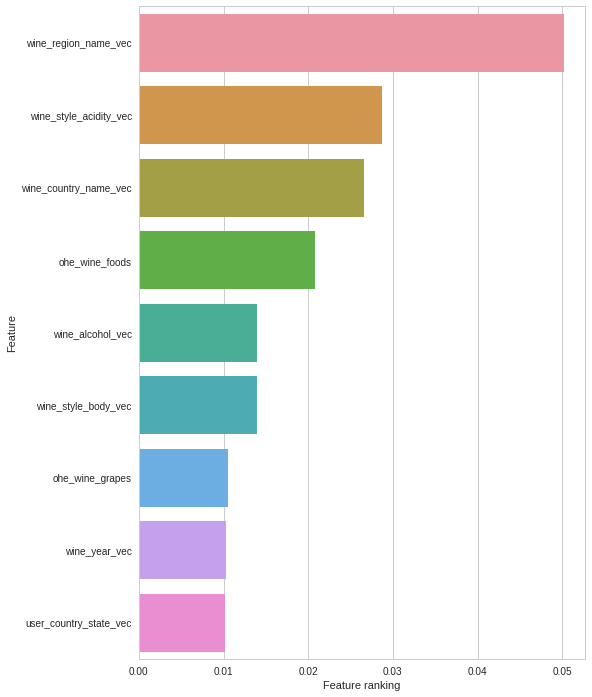

Features Importance using  scaledFeatures_note


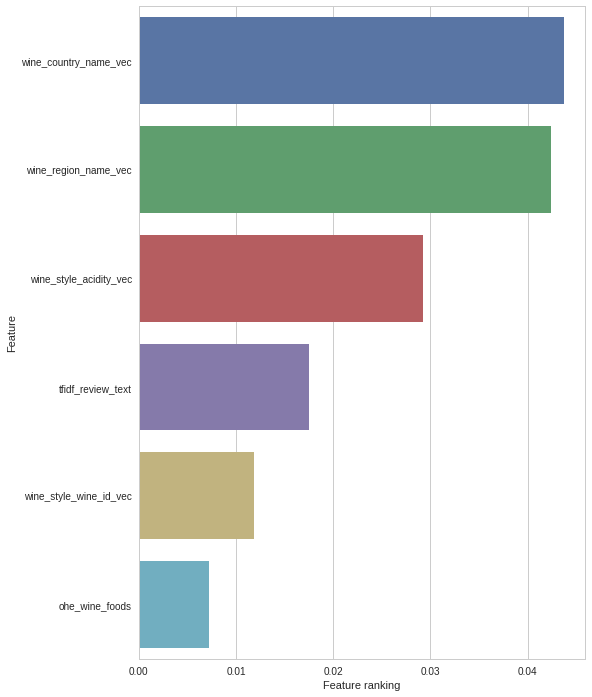

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns 

def ExtractFeatureImp(feat_imp_vec, newfeats_note):  
    # features sizes
    ohe_wine_foods_cat_size = 300 # num features for wine_foods
    ohe_wine_grapes_cat_size = 700 # num features for wine_grape
    tfidf_note_size = 3000 # num features for review text
    # list of num features for 'user_country_state_vec', 'wine_country_name_vec', 'wine_region_name_vec', 'wine_year_vec','wine_alcohol_vec','wine_style_acidity_vec','wine_style_body_vec','wine_style_wine_id_vec'
    ohe_category_size_list = [x - 1 for x in pip_model.stages[8].categorySizes] +[ohe_wine_foods_cat_size, ohe_wine_grapes_cat_size,+tfidf_note_size]

    # this list contains the index vector positions that delimit the different features within the overall features vector
    ohe_category_idx = [sum(ohe_category_size_list[:(i+1)]) for i in range(len(ohe_category_size_list))]  

    #create feature names list using feature importance index
    feature_names = []
    for idx in range(len(feat_imp_vec)):
        for idx_cat in range(len(ohe_category_idx)):
          if idx < ohe_category_idx[idx_cat]:
            feature_names.append(newfeats_note[idx_cat])
            break
        
    # merge feature names and feature importance
    feat_imp = []  
    for feature, importance in zip(feature_names, feat_imp_vec):
        feat_imp.append((feature, importance))

    #sort
    feat_imp = sorted(feat_imp, key=(lambda x: x[1]), reverse=True)
    top_features = feat_imp[0:20]

    return top_features   # return top 20 feature importance
  
  
featuresCosls = ['scaledFeatures','scaledFeatures_note']
for fc in featuresCosls:
    print("Features Importance using ",fc)
    df = RandomForestRegressor(featuresCol=fc,maxDepth=15, numTrees=15)
    model = df.fit(data)
    feat_imp_vec = model.featureImportances
    top_features = ExtractFeatureImp(feat_imp_vec, newfeats_note)

    ## PLOTS Feature Importance
    feat_top_pd = pd.DataFrame(data=top_features, columns =['Feature','Feature ranking'])    
    result = feat_top_pd.groupby(["Feature"])['Feature ranking'].aggregate(np.mean).reset_index().sort_values('Feature ranking', ascending=False)
    plt.rcParams['figure.figsize']=(8,12)
    sns.set_style('whitegrid')
    ax = sns.barplot(x='Feature ranking', y='Feature', data=result, ci=None)
    ax.set(ylabel='Feature')
    ax.set(xlabel='Feature ranking')
    plt.show()

#  Disconnection from the BDG Apache Spark

In [ ]:
sc.stop()